# westcoast Function

In [27]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import warnings 


#Warnings
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr
import glob

In [28]:
# great start will!
# let's get this function to the next level
#   -  instead of only looking into one file, let's search all the data files that have dataa in the west coast
#   -  for that, use hard coded relative directory (../saildrone_data), and use glob to get all the file names
#   -  open each, filter, and compile all into a single dataset (check meg's function or ask meg)
#   -  make a final map plot of all the data points

## Compile_Datasets Function

#### Compile_Datasets is used in westcoast to aggregate all cruise data

In [29]:
def Compile_Datasets(fn_list_in):


    # fn_list_in: list of strings with the file names, or filename(string), or "all"
    # returns: compiled list
    fn_list = []
    
    ddir = "/shared/users/mgarciareyes/saildrone_data"
    
    # Make sure the fn_list_in is formatted correctly
    if(fn_list_in == "all"):
        
        fn_list = glob.glob(ddir+ '/*.nc')
    elif(type(fn_list_in) == 'list' and type(fn_list_in[0]) == 'string'):
        fn_list = fn_list_in
    elif(type(fn_list_in) == 'string'):
        fn_list[0] = fn_list_in
    else: 
        raise Exception("first argument to 'Compile_Data_Set_And_Graph' function must be; a list of file names, a file name, or \"all\"")
        
    print()
    
    # open the first dataset
    sail = xr.open_dataset(fn_list[0])
    
    sail = sail.drop_vars("trajectory", errors='ignore')
    
    # give the first dataset a relative ID so all datasets can be differentiated
    sail["relativeID"] = 0
    # make lists for certain variables that remain constant for each dataset. these are used later in the last two cells
    yearList = [sail["time"][0].dt.year]
    durationList = [sail["time"][len(sail["time"]) - 1] - sail["time"][0]]
    # take the actual cruise ID from the dataset attributes and put it in a new list
    try:
        realID = [int(sail.attrs["id"])]
    except:
        realID = [fn_list[0]]
    sail["realID"] = realID[0]
    # add the duration back to the dataset
    sail["duration"] = durationList[0]

    # repeat previous steps for other datasets that need to be combined.

    if len(fn_list) > 1:
        for i in range(1, len(fn_list)):
            temp = xr.open_dataset(fn_list[i])
            temp = temp.drop_vars("trajectory", errors='ignore')
            temp["relativeID"] = i
            yearList.append(temp["time"][0].dt.year)
            
            try:
                realID.append(int(temp.attrs["id"]))
            except:
                realID.append(fn_list[i])
                
            tempDuration = temp["time"][len(temp["time"]) - 1] - temp["time"][0]
            temp["duration"] = tempDuration
            durationList.append(tempDuration)
            temp["realID"] = realID[i]
            sail = xr.concat([sail, temp], dim="time")
            temp.close()

    # reformat dates
    sail['date'] = mdates.date2num(sail['time'].dt.date)

    # ask what variable should be plotted
    return(sail)

## westcoast Function

In [77]:
#Author: William Gilmore
#Isolates data on the westcoast
def westcoast(upperLat, lowerLat):
    
    #upperLat: Upper acceptable latitude
    #lowerLat: Lower acceptable latitude
    # -function will discard all data not between upperLat and lowerLat
    
    
    ds = Compile_Datasets("all")
    
    
    #Removes data that is not within 300 km of shore
    
    #add ds = ds.where
    ds1 = ds.where(ds.dist_land <= 300)
    
    #Removes SF bay data
    ds1 = ds1.where(~(((ds1.lon > -122.5938) & (ds1.lat > 37.72783)) & ((ds1.lon < -122.2506620424831) & (ds1.lat < 38.094658646550556))) | ~(((ds1.lon > -122.38678630116495) & (ds1.lat > 37.430464705762226)) & ((ds1.lon < -121.99799777841487) & (ds1.lat < 37.81408437558721))))
    
    #Removes Data not between upperLat and lowerLat
    ds1 = ds1.where((ds1.lat > lowerLat) & (ds1.lat < upperLat))
    
    
    
    return(ds1)

## Sample Call

In [78]:
ds = westcoast(50, 20) # All westcoast voyages are within this range.

## Test Graph

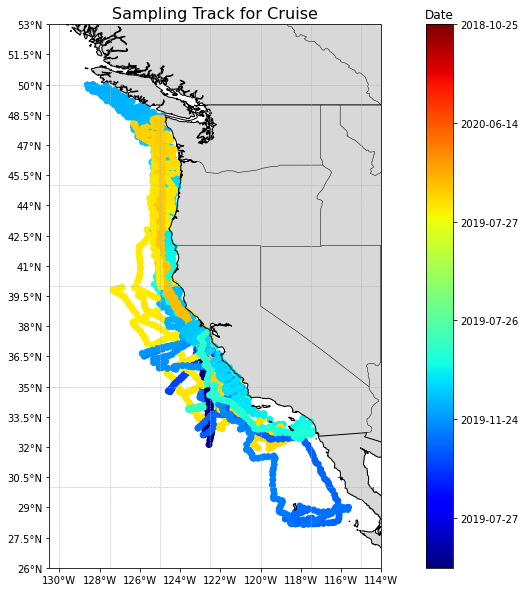

In [79]:
#create list of ticks for the x axis
default_x_ticks = range(0,len(ds['time']),divmod(len(ds['time']), 10)[0]) #selects out 10 evenly spaced dates from the data

#define latitude and longitude boundaries
latr = [27, 52] 
lonr = [-115, -130] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 72) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

# Plot track data, color by temperature
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = ds['lon'], y = ds['lat'], c = ds['date'], cmap='jet')
#plt.plot(ds['lon'], ds['lat'], ls = ':', c = 'navy', alpha = 0.4)
clb = fig.colorbar(sc, ticks=np.linspace(min(ds['date']), max(ds['date']), 11))
clb.ax.set_title('Date')
clb.set_ticklabels(ds['time'].dt.date[default_x_ticks].values)
plt.title('Sampling Track for Cruise', fontdict = {'fontsize' : 16})
plt.show()